# Libraries & Importing Data

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# models
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
og_cars = pd.read_excel('http://cdn.sundog-soft.com/Udemy/DataScience/cars.xls')
og_cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


I'm going to create a copy of the og dataframe above so it stays intact, and I'll prepare the copy for our model.

In [3]:
cars = og_cars.copy()

---

# EDA

Checking for missing data:

In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Model     804 non-null    object 
 4   Trim      804 non-null    object 
 5   Type      804 non-null    object 
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 75.5+ KB


No missing data. Dataset looks clean.

## Exploring features

To identify which features to keep, let's see what values they contain, and whether or not they correlate with each other (so that they don't violate the regression assumption of multicollinearity)

The list of available features in our dataset:

In [5]:
list(og_cars.columns)

['Price',
 'Mileage',
 'Make',
 'Model',
 'Trim',
 'Type',
 'Cylinder',
 'Liter',
 'Doors',
 'Cruise',
 'Sound',
 'Leather']

### *Mileage*

***Keep***

We can see in the Mileage vs price scatter plot below that the linear relationship isn't as pronounced as I thought it'd be. Usually the more miles a car has been driven, the more it'll lose value.

Let's investigate this.

At first glance, the price and mileage scatter plot below looks like a mess.

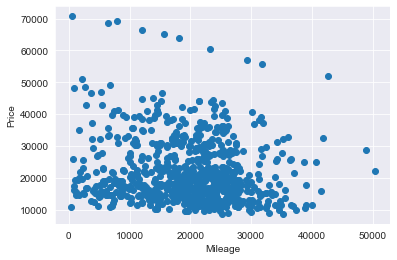

In [6]:
plt.scatter(cars.Mileage, cars.Price)
plt.xlabel('Mileage')
plt.ylabel('Price');

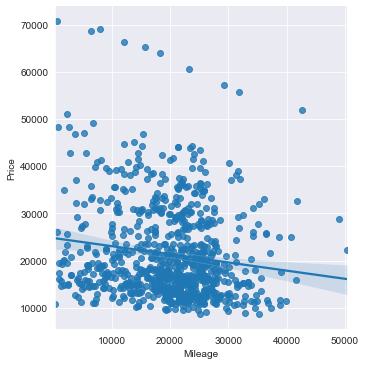

In [7]:
sns.lmplot(data=cars, x='Mileage', y='Price');

Getting the slope of linear regression line:

In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cars.Price, cars.Mileage)
slope

-0.1186145819911629

So they are correlated, but it seems pretty weak. Let's see what's happening here.

Let's break this down further by make and cylinders

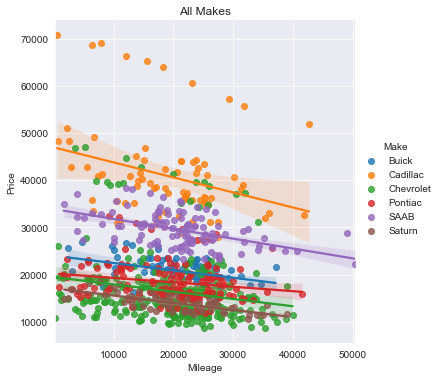

In [9]:
sns.lmplot(data=cars, x='Mileage', y='Price', hue='Make')
plt.title('All Makes');

Below we break it down further by Individual Make.

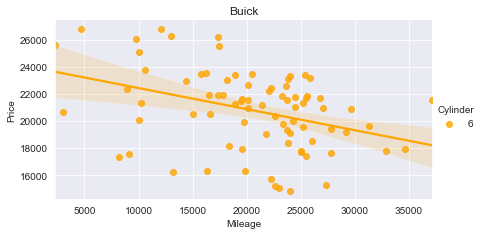

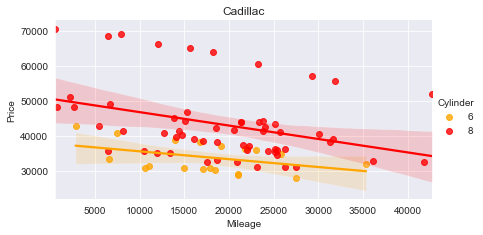

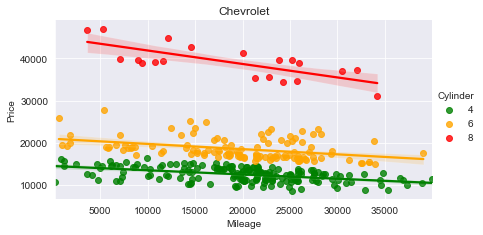

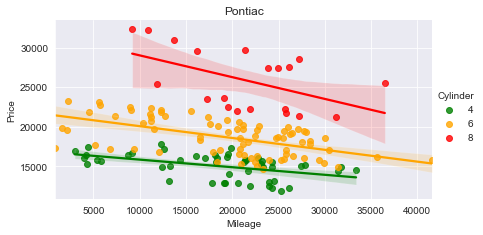

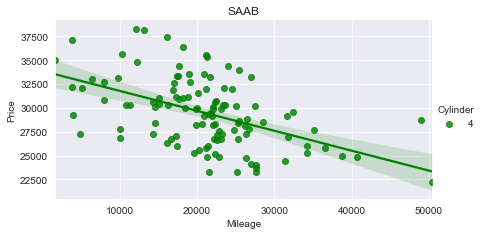

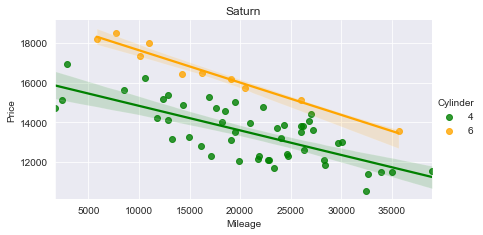

In [10]:
car_makes = list(cars.Make.unique())

for make in car_makes:
    sns.lmplot(data=cars[cars.Make == make], x='Mileage', y='Price', hue='Cylinder',
              height=3, aspect=2, palette={4:'g', 6:'orange', 8:'r'})
    plt.title(make);

Something interesting we can see from the plots above is that Chevrolet seems to hold it's value the best, while Saturn seems to lose the most value.

Now let's break it down by cylinders:

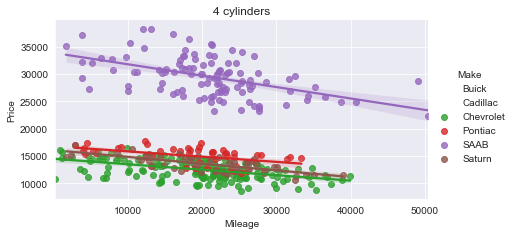

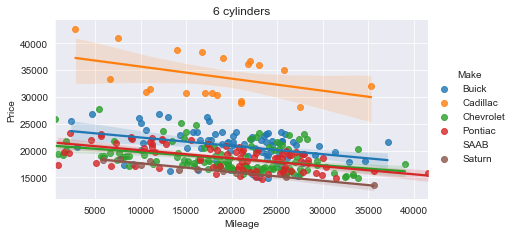

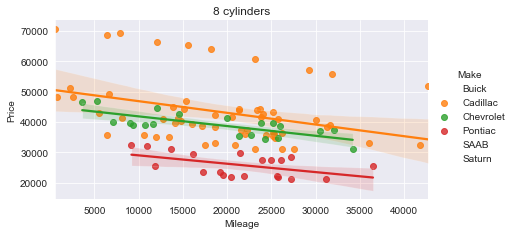

In [11]:
cylinders = sorted(list(cars.Cylinder.unique())) # sort list in ascending order after the list is created

for cylinder in cylinders:
    sns.lmplot(data=cars[cars.Cylinder == cylinder], x='Mileage', y='Price', hue='Make',
              height=3, aspect=2, hue_order=car_makes)
    plt.title(f'{cylinder} cylinders');

So price and mileage are more correlated than we could initally see. The level of correlation just depends on other predictors (make and cylinders).

### **Make**
***Keep***

Some makes are more expensive than others, so we're going to keep this feature as is for our pricing model

In [12]:
print('Makes: ', cars.Make.unique(), '\n')
cars.Make.value_counts()

Makes:  ['Buick' 'Cadillac' 'Chevrolet' 'Pontiac' 'SAAB' 'Saturn'] 



Chevrolet    320
Pontiac      150
SAAB         114
Buick         80
Cadillac      80
Saturn        60
Name: Make, dtype: int64

### **Model**

***Exclude***

Below we can see the unique values within the 'Model' column, and how often those unique values occur. 

The goal for now is to predict the price based on generic values: mileage, make, cylinders, etc. Model is too specific. So, given the scope of our project, we're going to exclude this feature from our model. 

In [13]:
print('Models: ', cars.Model.unique(), '\n')
print(cars.Model.value_counts())

Models:  ['Century' 'Lacrosse' 'Lesabre' 'Park Avenue' 'CST-V' 'CTS' 'Deville'
 'STS-V6' 'STS-V8' 'XLR-V8' 'AVEO' 'Cavalier' 'Classic' 'Cobalt'
 'Corvette' 'Impala' 'Malibu' 'Monte Carlo' 'Bonneville' 'G6' 'Grand Am'
 'Grand Prix' 'GTO' 'Sunfire' 'Vibe' '9_3' '9_3 HO' '9_5' '9_5 HO'
 '9-2X AWD' 'Ion' 'L Series'] 

Cavalier       60
AVEO           60
Malibu         60
Cobalt         50
Ion            50
9_3 HO         40
Impala         30
Deville        30
Monte Carlo    30
Vibe           30
Lacrosse       30
Grand Prix     30
Bonneville     30
9_5            30
G6             20
Corvette       20
Grand Am       20
9_3            20
Park Avenue    20
9_5 HO         20
Lesabre        20
GTO            10
STS-V6         10
Century        10
CST-V          10
Sunfire        10
L Series       10
CTS            10
XLR-V8         10
Classic        10
STS-V8         10
9-2X AWD        4
Name: Model, dtype: int64


In [14]:
del cars['Model']

### **Trim** 

***Feature Engineer. Delete 'Trim', keep 'Drivetrain'***

Looking at the unique values below, it seems that the last 2 strings inlcude the drivetrain- all/4 wheel drive (4D) vs 2 wheel drive (2D)

4D cars will almost always cost more than their 2D counterparts, so this is important for our price prediction model.

In [15]:
print('Models: ', cars.Trim.unique(), '\n')
print(cars.Trim.value_counts())

Models:  ['Sedan 4D' 'CX Sedan 4D' 'CXL Sedan 4D' 'CXS Sedan 4D' 'Custom Sedan 4D'
 'Limited Sedan 4D' 'Special Ed Ultra 4D' 'DHS Sedan 4D' 'DTS Sedan 4D'
 'Hardtop Conv 2D' 'LS Hatchback 4D' 'LS Sedan 4D' 'LT Hatchback 4D'
 'LT Sedan 4D' 'SVM Hatchback 4D' 'SVM Sedan 4D' 'Coupe 2D' 'LS Coupe 2D'
 'LS Sport Coupe 2D' 'LS Sport Sedan 4D' 'Conv 2D' 'SS Sedan 4D'
 'LS MAXX Hback 4D' 'LT MAXX Hback 4D' 'MAXX Hback 4D' 'LT Coupe 2D'
 'SS Coupe 2D' 'GXP Sedan 4D' 'SE Sedan 4D' 'SLE Sedan 4D' 'GT Sedan 4D'
 'GT Coupe 2D' 'GTP Sedan 4D' 'AWD Sportwagon 4D' 'GT Sportwagon'
 'Sportwagon 4D' 'Linear Conv 2D' 'Linear Sedan 4D' 'Aero Conv 2D'
 'Aero Sedan 4D' 'Arc Conv 2D' 'Arc Sedan 4D' 'Arc Wagon 4D'
 'Linear Wagon 4D' 'Aero Wagon 4D' 'Quad Coupe 2D' 'L300 Sedan 4D'] 

Sedan 4D               170
Coupe 2D                50
LS Sedan 4D             50
LS Coupe 2D             30
LT Sedan 4D             30
Quad Coupe 2D           20
GT Sedan 4D             20
Arc Sedan 4D            20
SE Sedan 4D    

Let's check if the last 2 strings of all the values here contain the drivetrain designation:

In [16]:
cars.Trim.str[-2:].unique() 
# using string slicing to get the last 2 strings of each of the values within this col, and then unique values

array(['4D', '2D', 'on'], dtype=object)

We have a 3rd unique value here. Let's investigate this:

In [17]:
cars[cars.Trim.str[-2:] == 'on'] # look at trims where the last 2 strings are 'on'

,Price,Mileage,Make,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
610,17803.279089,12303,Pontiac,GT Sportwagon,Wagon,4,1.8,4,1,1,1
611,16353.096517,16078,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,1,0
612,15977.911084,17053,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,1
613,15568.974237,18206,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,0
614,15589.780483,21307,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,0
615,15730.046266,21391,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,1,1
616,15802.652861,21461,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,0
617,15086.899592,27438,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,1
618,14396.270557,31424,Pontiac,GT Sportwagon,Wagon,4,1.8,4,0,0,0
619,14869.282067,31791,Pontiac,GT Sportwagon,Wagon,4,1.8,4,1,1,1


They're all the same car. We can either discard these rows since they make up a small % (1.2%) of our entire dataset, OR try to figure out if this car is 4D or 2D. 

Let's attempt the latter. 

Let's focus on the Type of this car. Since it's a 'Wagon', let's see what kind of drivetrain the other wagons in the dataset have.

In [18]:
cars[cars.Type == 'Wagon'].Trim.unique()

array(['AWD Sportwagon 4D', 'GT Sportwagon', 'Sportwagon 4D',
       'Arc Wagon 4D', 'Linear Wagon 4D', 'Aero Wagon 4D'], dtype=object)

They're all '4D' (excluding 'GT Sportwagon')

We can investigate further by looking at trims that contain the string 'Sportwagon'

In [19]:
cars[cars.Trim.str.contains('Sportwagon')]

,Price,Mileage,Make,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
600,16391.926573,18096,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,1,1,0
601,16033.930618,18391,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,0,1,1
602,16106.827221,19465,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,1,0,0
603,16551.219566,19531,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,1,1,1
604,17325.269543,19894,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,1,0,0
605,16078.665491,22779,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,0,0,1
606,15297.835973,23062,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,0,0,0
607,15505.293806,24239,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,1,0,0
608,15174.346613,27887,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,0,0,0
609,14546.884814,33374,Pontiac,AWD Sportwagon 4D,Wagon,4,1.8,4,0,1,1


They're all the same make and model. And all the 'Sportwagons' are labeled 4D, except for the GT Sportwagon.  

Therefore, I'm going to assume that the GT Sportwagon is 4D.

Alternatively, we could have just googled 'pontiac vibe gt sportwagon' and confimed that it indeed has a 4D drivetrain.

Now that we have figured out the drivetrains, let's make a new column for it:

In [20]:
cars['Drivetrain'] = cars.Trim.str[-2:]
cars

,Price,Mileage,Make,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather,Drivetrain
0,17314.103129,8221,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,1,4D
1,17542.036083,9135,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,0,4D
2,16218.847862,13196,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,0,4D
3,16336.913140,16342,Buick,Sedan 4D,Sedan,6,3.1,4,1,0,0,4D
4,16339.170324,19832,Buick,Sedan 4D,Sedan,6,3.1,4,1,0,1,4D
...,...,...,...,...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,0,0,4D
800,16175.957604,19095,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4D
801,15731.132897,20484,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4D
802,15118.893228,25979,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4D


Converting 'on' to 4D:

In [21]:
cars.Drivetrain.replace('on', '4D', inplace=True)
cars.Drivetrain.unique()

array(['4D', '2D'], dtype=object)

*FURTHERMORE*, let's go ahead and change the values to numerical, so that we have one less categorical feature to deal with

In [22]:
cars.Drivetrain.replace(['4D', '2D'],[4, 2], inplace=True)
cars

,Price,Mileage,Make,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather,Drivetrain
0,17314.103129,8221,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,1,4
1,17542.036083,9135,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,0,4
2,16218.847862,13196,Buick,Sedan 4D,Sedan,6,3.1,4,1,1,0,4
3,16336.913140,16342,Buick,Sedan 4D,Sedan,6,3.1,4,1,0,0,4
4,16339.170324,19832,Buick,Sedan 4D,Sedan,6,3.1,4,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,0,0,4
800,16175.957604,19095,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4
801,15731.132897,20484,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4
802,15118.893228,25979,Saturn,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0,4


Delete the 'Trim' column

In [23]:
del cars['Trim']

### **Type**

***Keep***

While Type and Doors are correlated, we can see that the average price of each Type of car is different, which will be important for the pricing model. Therefore I'm going to keep both Type and Doors as features.

Checking the unique values for 'Type':

In [24]:
print('Type: ', cars.Type.unique(), '\n')
cars.Type.value_counts()

Type:  ['Sedan' 'Convertible' 'Hatchback' 'Coupe' 'Wagon'] 



Sedan          490
Coupe          140
Wagon           64
Hatchback       60
Convertible     50
Name: Type, dtype: int64

Below we can see that the # of 'Doors' is correlated with the 'Type' of car. All sedans, hatchbacks and wagons have 4 doors, and all convertibles and coupes have 2 doors.

In [38]:
for doors in list(cars.Doors.unique()):
    print(f'{doors} doors: ', cars[cars.Doors == doors].Type.unique())

4 doors:  ['Sedan' 'Hatchback' 'Wagon']
2 doors:  ['Convertible' 'Coupe']


Let's look at the mean price of each type of 4-door and 2-door cars.

In [45]:
for car_type in list(cars.Type.unique()):
    print(f'Average Price of {car_type}: ', cars[cars.Type == car_type].Price.mean())

Average Price of Sedan:  21067.92748740671
Average Price of Convertible:  40831.705847173405
Average Price of Hatchback:  14170.92780922892
Average Price of Coupe:  17726.93183140073
Average Price of Wagon:  22859.245356127718


Visualizing the average price and distribution of each type of 2-door and 4-door cars:

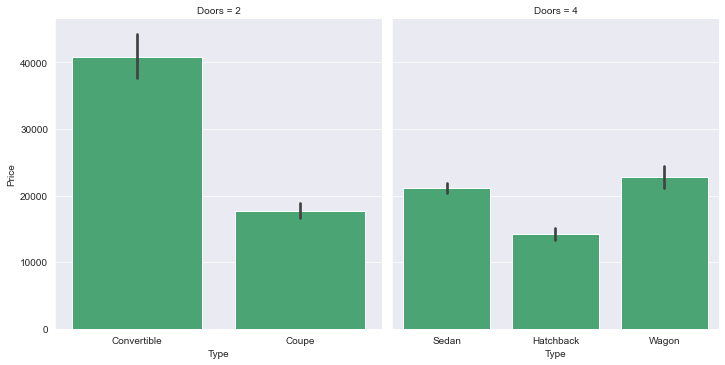

In [82]:
sns.catplot(x='Type', y='Price', col='Doors', data=cars, kind='bar', color='mediumseagreen', sharex=False);

As we can see above, the average price of each type of 2-door and 4-door car is different. For 2-door cars, a convertible is twice as more expensive than a coupe. And for 4-door cars, a wagon on average costs more than sedans and hatchbacks.

### Cylinder vs Liter

***Keep 'Cylinder', exclude 'Liter'***

To avoid multicollinearity, we're only going to keep Cylinder. This is because as the number of cylinders increase, so does the engine size (liters). They're directly correlated, therefore no need to include both in our model.

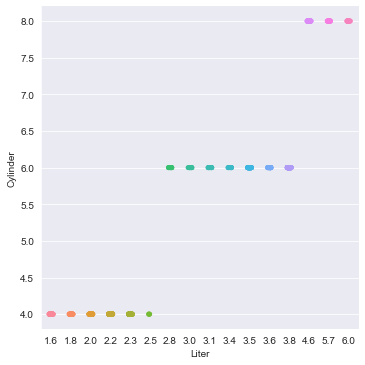

In [87]:
sns.catplot(data=cars, y=cars.Cylinder, x=cars.Liter);

4 cylinder engines are smaller, measuring between 1.6 and 2.5 liters.

6 cylinder engines measure between 2.8 and 3.8 liters.

8 cylinder engines measure between 4.6 and 6 liters. 

So we'll 

In [27]:
del cars['Liter']

### OHE categoricals

Isolating categorical features:


In [18]:
cat_features = [col for col in cars.columns if cars[col].dtype=='O']
cat_features

['Make', 'Drivetrain']

One Hot Encoding:

In [19]:
ohe = OneHotEncoder()

cat_ohe = ohe.fit_transform(cars[cat_features])

ohe_df = pd.DataFrame(cat_ohe.todense(),
                     index = cars.index,
                     columns = ohe.get_feature_names(cars[cat_features].columns))

ohe_df

,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn,Drivetrain_2D,Drivetrain_4D
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
799,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
800,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
801,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
802,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Replacing the categorical columns in our dataset with the above